In [18]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma
from scipy.signal import convolve

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers

import torch
import torch.nn as nn
import torch.optim as optim

import nibabel as nib

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)



class model_bold

Convolved BOLD Signal (y_conv): Should display peaks corresponding to the event onsets, shaped by the HRF.

Alignment Time (alignment_ts): Should show the same BOLD signal shifted forward by the specified hemodynamic delay, aligning the peak of the BOLD response with the appropriate neural event.

In [10]:
class ModelBOLD:
    @staticmethod
    def hrf(tr, duration=32.0):
        """
        Create a canonical Hemodynamic Response Function (HRF) using a double-gamma model.

        Args:
            tr (float): Repetition time (seconds).
            duration (float): Duration to model the HRF (seconds).

        Returns:
            hrf (numpy.ndarray): The HRF sampled at TR intervals.
        """
        # Parameters for the double-gamma HRF
        peak1 = 6
        undershoot = 16
        dispersion1 = 1
        dispersion2 = 1
        ratio = 6
        scale = 1

        t = np.linspace(0, duration, int(duration / tr))
        hrf = (gamma.pdf(t, peak1 / dispersion1, scale=dispersion1) -
               gamma.pdf(t, undershoot / dispersion2, scale=dispersion2) / ratio)
        hrf = hrf / np.max(hrf)  # Normalize
        return hrf

    @staticmethod
    def convolve_events_with_hrf(event_onsets, tr=1.5, duration=32.0, hemodynamic_delay=7.5):
        """
        Convolve event onsets with HRF and apply hemodynamic delay.

        Args:
            event_onsets (numpy.ndarray): Array of event onset times in seconds.
            tr (float): Repetition time (seconds).
            duration (float): Duration to model the HRF (seconds).
            hemodynamic_delay (float): Hemodynamic delay in seconds.

        Returns:
            y_conv (numpy.ndarray): The convolved and delayed BOLD signal.
            alignment_ts (numpy.ndarray): Alignment timestamps adjusted for hemodynamic delay.
        """
        # Generate HRF
        hrf = ModelBOLD.hrf(tr=tr, duration=duration)

        # Define total duration
        if len(event_onsets) == 0:
            print("No event onsets provided.")
            return np.array([]), np.array([])
        
        total_duration = event_onsets[-1] + duration
        num_time_points = int(np.ceil(total_duration / tr))
        time_vector = np.arange(0, num_time_points * tr, tr)

        # Create binary event series
        event_series = np.zeros_like(time_vector)
        for onset in event_onsets:
            idx = np.where(time_vector >= onset)[0]
            if len(idx) > 0:
                event_series[idx[0]] = 1  # Mark the first TR >= onset

        # Convolve event series with HRF
        y_conv_full = convolve(event_series, hrf)[:num_time_points]

        # Normalize y_conv
        if np.max(y_conv_full) != 0:
            y_conv = y_conv_full / np.max(y_conv_full)
        else:
            y_conv = y_conv_full

        # Alignment timestamps: align the convolved signal to BOLD data by applying hemodynamic delay
        delay_slices = int(hemodynamic_delay / tr)
        alignment_ts = np.pad(y_conv, (delay_slices, 0), 'constant')[:num_time_points]

        return y_conv, alignment_ts

Matched nifti with stimulus files

In [ ]:
def get_run_prefixes():
    """
    Generate run prefixes for participants s05 and s14.

    Returns:
        list: List of run prefixes.
    """
    s05 = [f"s05_run{str(i).zfill(3)}" for i in range(1, 7)]  # s05_run001 to s05_run006
    s14 = [f"s14_run{str(i).zfill(3)}" for i in range(2, 7)]  # s14_run002 to s14_run006
    return s05 + s14

def match_files(input_dir, prefixes):
    """
    Match NIfTI files with their corresponding CSV label files.

    Args:
        input_dir (str): Directory containing the data files.
        prefixes (list): List of file prefixes.

    Returns:
        list of tuples: Each tuple contains paths to a matched NIfTI and CSV file.
    """
    matched = []
    missing_files = {'nifti': [], 'csv': []}
    for prefix in prefixes:
        nifti_path = os.path.join(input_dir, f"{prefix}.nii")
        csv_path = os.path.join(input_dir, f"{prefix}_orientations.csv")
        nifti_exists = os.path.isfile(nifti_path)
        csv_exists = os.path.isfile(csv_path)

        if nifti_exists and csv_exists:
            matched.append((nifti_path, csv_path))
            print(f"Matched: {nifti_path} <--> {csv_path}")
        else:
            if not nifti_exists:
                missing_files['nifti'].append(nifti_path)
            if not csv_exists:
                missing_files['csv'].append(csv_path)

    if missing_files['nifti'] or missing_files['csv']:
        print(f"Warning: Missing NIfTI files: {missing_files['nifti']}")
        print(f"Warning: Missing CSV files: {missing_files['csv']}")

    return matched


Load and process voxel and event data

In [20]:
def get_measurement_df(nifti_path, csv_path, required_columns, rows_per_slice, delay_rows, voxel_indices=None):
    """
    Load and process voxel and event data, applying hemodynamic delay.

    Args:
        nifti_path (str): Path to the NIfTI file.
        csv_path (str): Path to the CSV file.
        required_columns (set): Required columns in the CSV.
        rows_per_slice (int): Number of CSV rows per NIfTI slice.
        delay_rows (int): Number of rows to delay for hemodynamic alignment.
        voxel_indices (list of tuples, optional): Specific voxels to extract.

    Returns:
        tuple: (processed DataFrame, list of voxel column names)
    """
    # Load NIfTI data
    try:
        nii_img = nib.load(nifti_path)
        data = nii_img.get_fdata()  # Shape: (X, Y, Z, Time)
        print(f"Loaded NIfTI file: {nifti_path} with shape {data.shape}")
    except Exception as e:
        print(f"Error loading NIfTI file {nifti_path}: {e}")
        return None, []

    # Load CSV event data
    try:
        labels_df = pd.read_csv(csv_path)
        print(f"Loaded CSV file: {csv_path} with {len(labels_df)} entries")
    except Exception as e:
        print(f"Error loading CSV file {csv_path}: {e}")
        return None, []

    # Check for required columns
    if not required_columns.issubset(labels_df.columns):
        missing = required_columns - set(labels_df.columns)
        print(f"Error: Missing required columns {missing} in {csv_path}")
        return None, []

    # Mapping: Each slice maps to slice_index * rows_per_slice
    slice_indices = np.arange(0, data.shape[-1])
    csv_indices = slice_indices * rows_per_slice  # No delay applied here

    # Ensure indices are within bounds
    valid_mask = (csv_indices >= 0) & (csv_indices < len(labels_df))
    csv_indices = csv_indices[valid_mask].astype(int)
    slice_indices = slice_indices[valid_mask]

    if len(csv_indices) == 0:
        print("Warning: No valid CSV indices after applying delay. Skipping this file.")
        return None, []

    # Extract filtered labels
    filtered_labels = labels_df.iloc[csv_indices].reset_index(drop=True)
    print(f"Filtered labels shape: {filtered_labels.shape}")

    # Extract 'Time' and 'Orientation'
    if 'Time' in required_columns:
        event_onsets = filtered_labels['Time'].astype(float).values  # Ensure 'Time' is float
    if 'Orientation' in required_columns:
        orientations = filtered_labels['Orientation'].values

    # Extract voxel data at slice_indices
    extracted_data = data[..., slice_indices]  # Shape: (X, Y, Z, num_slices)
    print(f"Extracted voxel data shape: {extracted_data.shape}")

    # Reshape voxel data to (num_slices, voxel_features)
    num_slices = extracted_data.shape[-1]
    voxel_features = extracted_data.transpose(3, 0, 1, 2).reshape(num_slices, -1)  # Shape: (num_slices, voxel_features)
    print(f"Reshaped voxel features to shape: {voxel_features.shape}")

    # Select voxel_indices if provided, else select top 1000 most variable voxels
    if voxel_indices is None:
        variances = np.var(voxel_features, axis=0)
        top_voxel_indices = np.argsort(variances)[-1000:]  # Select top 1000
        voxel_features = voxel_features[:, top_voxel_indices]
        voxel_list = [f"voxel_{i}" for i in top_voxel_indices]
        print(f"Selected top {len(top_voxel_indices)} most variable voxels based on variance.")
    else:
        # Convert voxel coordinates to flat indices
        X, Y, Z = data.shape[:3]
        flat_indices = [x * Y * Z + y * Z + z for (x, y, z) in voxel_indices]
        voxel_features = voxel_features[:, flat_indices]
        voxel_list = [f"voxel_{x}_{y}_{z}" for (x, y, z) in voxel_indices]
        print(f"Selected {len(voxel_indices)} specified voxels.")

    # Scale voxel features
    scaler = MinMaxScaler()
    voxel_features_scaled = scaler.fit_transform(voxel_features)
    print(f"Scaled voxel features with MinMaxScaler.")

    # Create voxel DataFrame
    voxel_df = pd.DataFrame(voxel_features_scaled, columns=voxel_list)
    print(f"Voxel DataFrame shape: {voxel_df.shape}")

    # Combine voxel data with event data
    df = pd.concat([filtered_labels, voxel_df], axis=1)
    print(f"Combined DataFrame shape: {df.shape}")

    # Remove the first and last rows to eliminate incomplete data
    df = df.iloc[1:-1].reset_index(drop=True)
    print(f"DataFrame shape after removing first and last rows: {df.shape}")

    return df, voxel_list


In [13]:
def visualize_alignment(y_conv, alignment_ts, participant_id, run_id):
    """
    Visualize the convolved BOLD signal and alignment timestamps.

    Args:
        y_conv (numpy.ndarray): Convolved BOLD signal.
        alignment_ts (numpy.ndarray): Alignment timestamps.
        participant_id (str): Participant ID.
        run_id (str): Run ID.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(y_conv, label='Convolved BOLD Signal (y_conv)')
    plt.plot(alignment_ts, label='Alignment Timestamps (alignment_ts)', alpha=0.7)
    plt.xlabel('Time Points')
    plt.ylabel('Normalized Signal')
    plt.title(f'BOLD Signal Alignment for Participant {participant_id}, Run {run_id}')
    plt.legend()
    plt.show()

In [21]:
def load_delay_data(input_dir, prefixes, required_columns, voxel_indices=None, 
                   seconds_per_slice=1.5, rows_per_slice=14, delay_seconds=7.5):
    """
    Load and process data for multiple file pairs.

    Args:
        input_dir (str): Directory containing the data files.
        prefixes (list): List of file prefixes.
        required_columns (set): Set of required columns in the CSV files.
        voxel_indices (list of tuples, optional): Specific voxels to extract.
        seconds_per_slice (float): Duration each NIfTI slice represents in seconds.
        rows_per_slice (int): Number of CSV rows corresponding to one NIfTI slice.
        delay_seconds (float): Hemodynamic delay in seconds.

    Returns:
        tuple: (data_x_list, data_y_list, scalers, labels_list)
            - data_x_list: List of feature matrices.
            - data_y_list: List of target vectors.
            - scalers: List of scalers used for voxel features.
            - labels_list: List of DataFrames with orientation labels and voxel data.
    """
    data_x_list = []
    data_y_list = []
    scalers = []
    labels_list = []

    matched_files = match_files(input_dir, prefixes)
    print(f"\nTotal matched file pairs: {len(matched_files)}\n")

    # Calculate rows corresponding to the delay
    seconds_per_row = seconds_per_slice / rows_per_slice
    delay_rows = int(delay_seconds / seconds_per_row)
    print(f"Delay Parameters:")
    print(f"  Seconds per slice: {seconds_per_slice}")
    print(f"  Rows per slice: {rows_per_slice}")
    print(f"  Delay (seconds): {delay_seconds}")
    print(f"  Delay (rows): {delay_rows}\n")

    for idx, (nifti_path, csv_path) in enumerate(matched_files, 1):
        print(f"Processing file pair {idx}/{len(matched_files)}:")
        try:
            # Extract participant_id and run_id from the prefix
            prefix = os.path.splitext(os.path.basename(nifti_path))[0]
            participant_id, run_id = prefix.split('_')

            # Load and process data
            df, voxel_list = get_measurement_df(
                nifti_path=nifti_path,
                csv_path=csv_path,
                required_columns=required_columns,
                rows_per_slice=rows_per_slice,
                delay_rows=delay_rows,
                voxel_indices=voxel_indices
            )

            if df is None:
                print(f"  Skipping file pair due to previous errors.\n")
                continue

            print(f"  Measurement DataFrame shape after cleaning: {df.shape}")
            print(f"  Voxel columns: {voxel_list}\n")

            # Extract event onsets for convolution
            event_onsets = df['Time'].values if 'Time' in df.columns else np.array([])
            if len(event_onsets) == 0:
                print("  No event onsets found. Skipping convolution.\n")
                continue

            # Convolve events with HRF and apply hemodynamic delay
            y_conv, alignment_ts = ModelBOLD.convolve_events_with_hrf(
                event_onsets=event_onsets,
                tr=seconds_per_slice,
                duration=32.0,
                hemodynamic_delay=delay_seconds
            )

            if len(y_conv) == 0:
                print("  Empty convolved signal. Skipping this file.\n")
                continue

            # Optionally visualize the alignment
            # visualize_alignment(y_conv, alignment_ts, participant_id, run_id)

            # Add the convolved signal and alignment timestamps to the DataFrame
            df['y_conv'] = y_conv
            df['alignment_ts'] = alignment_ts

            # Normalize 'y_conv' and 'alignment_ts'
            scaler_y = MinMaxScaler()
            df['y_conv'] = scaler_y.fit_transform(df[['y_conv']])
            df['alignment_ts'] = scaler_y.fit_transform(df[['alignment_ts']])

            # Extract 'Orientation' as target
            if 'Orientation' not in df.columns:
                print(f"  Error: 'Orientation' column missing in {csv_path}. Skipping this file.\n")
                continue

            orientations = df['Orientation'].values

            # Prepare feature matrix (voxel_features) and target vector (orientations)
            features = df[voxel_list + ['alignment_ts']].values  # Including alignment_ts as a feature
            target = df['y_conv'].values.reshape(-1, 1, 1).astype(np.float32)  # Shape: (num_time_points, 1, 1)

            # Scale features
            scaler_features = MinMaxScaler()
            features_scaled = scaler_features.fit_transform(features)

            # Reshape features to (M, 1, N)
            data_x = features_scaled.reshape(features_scaled.shape[0], 1, features_scaled.shape[1]).astype(np.float32)
            data_y = target  # Already shaped as (M, 1, 1)

            # Append to lists
            data_x_list.append(data_x)
            data_y_list.append(data_y)
            labels_list.append(df[['Orientation'] + voxel_list])

            # Store the scaler
            scalers.append(scaler_features)

            # Debugging Information
            print(f"  Feature matrix 'data_x' shape: {data_x.shape}")
            print(f"  Target vector 'data_y' shape: {data_y.shape}")
            print(f"  Processed {data_x.shape[0]} time points and {data_x.shape[2]} features.\n")

        except Exception as e:
            print(f"  Error processing {nifti_path} and {csv_path}: {e}\n")

    print("Data loading and processing complete.\n")
    print(f"Total X sets loaded: {len(data_x_list)}")
    print(f"Total y sets loaded: {len(data_y_list)}")
    print(f"Total labels sets loaded: {len(labels_list)}\n")

    return data_x_list, data_y_list, scalers, labels_list

In [22]:
def main():
    """
    Main function to execute the data processing workflow.
    """
    # Define the data directory
    DATA_DIR = '/Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR'      

    # Generate run prefixes
    prefixes = get_run_prefixes()

    # Define required columns in CSV
    required_columns = {'Orientation', 'Time'}  # Adjust based on your CSV structure

    # Define delay parameters
    seconds_per_slice = 1.5   # Duration each NIfTI slice represents in seconds
    rows_per_slice = 14       # Number of CSV rows corresponding to one NIfTI slice
    delay_seconds = 7.5       # Hemodynamic delay in seconds

    # Optional: Specify voxel indices if you have a predefined list
    # For example: voxel_indices = [(30, 40, 50), (32, 42, 52), ...]
    voxel_indices = None  # Set to None to select top 1000 most variable voxels

    # Load and process data
    data_x_list, data_y_list, scalers, labels_list = load_delay_data(
        input_dir=DATA_DIR,
        prefixes=prefixes,
        required_columns=required_columns,
        voxel_indices=voxel_indices,
        seconds_per_slice=seconds_per_slice,
        rows_per_slice=rows_per_slice,
        delay_seconds=delay_seconds
    )

    # Access the first dataset
    if len(data_x_list) > 0:
        first_data_x = data_x_list[0]
        first_data_y = data_y_list[0]
        first_labels = labels_list[0]
        print(f"First dataset - X shape: {first_data_x.shape}, y shape: {first_data_y.shape}")

if __name__ == "__main__":
    main()
    

Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run001.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run001_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run002.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run002_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run003.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run003_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run004.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run004_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run005.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run005_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run006.ni

In [2]:
#Ensure the model_bold class is defined as above
#def get_measurement_df(participant_id, run_id, csv_path):
#def visualize_alignment_ts(alignment_ts):

def get_run_prefixes():
    """Generate run prefixes for s05 and s14 runs."""
    s05 = [f"s05_run{str(i).zfill(3)}" for i in range(1, 7)]  # s05_run001 to s05_run006
    s14 = [f"s14_run{str(i).zfill(3)}" for i in range(2, 7)]  # s14_run002 to s14_run006
    return s05 + s14

def match_files(input_dir, prefixes):
    """Match NIfTI files with their corresponding CSV label files."""
    matched = []
    missing_files = {'nifti': [], 'csv': []}
    for prefix in prefixes:
        nifti_path = os.path.join(input_dir, f"{prefix}.nii")
        csv_path = os.path.join(input_dir, f"{prefix}_orientations.csv")
        nifti_exists = os.path.isfile(nifti_path)
        csv_exists = os.path.isfile(csv_path)

        if nifti_exists and csv_exists:
            matched.append((nifti_path, csv_path))
            print(f"Matched: {nifti_path} <--> {csv_path}")
        else:
            if not nifti_exists:
                missing_files['nifti'].append(nifti_path)
            if not csv_exists:
                missing_files['csv'].append(csv_path)

    if missing_files['nifti'] or missing_files['csv']:
        print(f"Warning: Missing NIfTI files: {missing_files['nifti']}")
        print(f"Warning: Missing CSV files: {missing_files['csv']}")
    
    return matched

def load_delay_data(input_dir, prefixes, required_columns, scaler=None, 
              seconds_per_slice=1.5, rows_per_slice=14, delay_seconds=7.5, debug_slice_count=5):
    """
    Load NIfTI data and corresponding CSV labels, map each slice to every set number of CSV rows based on duration,
    apply a delay to align peak BOLD responses to their corresponding orientation stimuli,
    scale voxel data, and collect separate X and y for each file.

    Args:
        input_dir (str): Directory containing the data files.
        prefixes (list): List of file prefixes.
        required_columns (set): Set of required columns in the CSV files.
        scaler (MinMaxScaler, optional): Scaler for normalizing voxel data. Defaults to None.
        seconds_per_slice (float, optional): Duration each NIfTI slice represents in seconds. Defaults to 1.5.
        rows_per_slice (int, optional): Number of CSV rows corresponding to one NIfTI slice based on duration. Defaults to 14.
        delay_seconds (float, optional): Delay in seconds to align BOLD response with stimulus. Defaults to 7.5.

    Returns:
        tuple: Tuple containing:
            - X_list (list of np.ndarray): List of scaled voxel data arrays per file.
            - y_list (list of np.ndarray): List of orientation labels arrays per file.
            - scalers (list of MinMaxScaler): List of fitted scaler objects per file.
    """
    X_list = []       # List to store scaled voxel data arrays for each file
    y_list = []       # List to store orientation labels arrays for each file
    scalers = []      # List to store scaler objects for each file
    labels_list = []  # List to store filtered labels for each file

    matched_files = match_files(input_dir, prefixes)
    print(f"Total matched file pairs: {len(matched_files)}\n")

    # Calculate rows corresponding to the delay
    seconds_per_row = seconds_per_slice / rows_per_slice  # ≈0.107 seconds per row
    delay_rows = int(delay_seconds / seconds_per_row)     # 7.5 / 0.107 ≈70 rows
    print(f"Delay Parameters:")
    print(f"  Seconds per slice: {seconds_per_slice}")
    print(f"  Rows per slice: {rows_per_slice}")
    print(f"  Delay (seconds): {delay_seconds}")
    print(f"  Delay (rows): {delay_rows}\n")

    for idx, (nifti_path, csv_path) in enumerate(matched_files, 1):
        print(f"Processing file pair {idx}/{len(matched_files)}:")
        try:
            # Load NIfTI data
            nii_img = nib.load(nifti_path)
            data = nii_img.get_fdata()
            print(f"  Loaded NIfTI: {nifti_path} with shape {data.shape}")

            # Load CSV labels
            labels_df = pd.read_csv(csv_path)
            print(f"  Loaded CSV: {csv_path} with {len(labels_df)} entries")

            if required_columns.issubset(labels_df.columns):
                # Mapping: Each slice maps to slice_index * rows_per_slice - delay_rows
                slice_indices = np.arange(0, data.shape[-1])
                csv_indices = slice_indices * rows_per_slice - delay_rows  # Apply delay

                # Ensure indices are within CSV length and non-negative
                valid_mask = (csv_indices >= 0) & (csv_indices < len(labels_df))
                csv_indices = csv_indices[valid_mask].astype(int)
                slice_indices = slice_indices[valid_mask]

                if len(csv_indices) == 0:
                    print("  Warning: No valid CSV indices after applying delay. Skipping this file.\n")
                    continue

                filtered_labels = labels_df.iloc[csv_indices].reset_index(drop=True)
                labels_list.append(filtered_labels)  # Store the filtered labels

                if 'Time' in required_columns:
                    valid_times = filtered_labels['Time'].astype(float)  # Assuming 'Time' is in seconds
                if 'Orientation' in required_columns:
                    orientations = filtered_labels['Orientation']

                extracted_data = data[..., slice_indices]
                matched_orientations = orientations.values

                # Reshape voxel data to (num_slices, voxel_features)
                num_slices = extracted_data.shape[-1]
                voxel_features = extracted_data.reshape(-1, extracted_data.shape[0] * extracted_data.shape[1] * extracted_data.shape[2])

                # Initialize a new scaler for the current file
                current_scaler = MinMaxScaler()
                voxel_features_scaled = current_scaler.fit_transform(voxel_features)
                scalers.append(current_scaler)

                # Append to X_list and y_list
                X_list.append(voxel_features_scaled)  # Shape: (num_slices, num_features)
                y_list.append(matched_orientations)   # Shape: (num_slices,)

                # Print shapes for current file
                print(f"  X shape for '{os.path.basename(nifti_path)}': {voxel_features_scaled.shape}")
                print(f"  y shape for '{os.path.basename(csv_path)}': {matched_orientations.shape}")

                # Print first 5 entries of 'Time' and 'Orientation'
                print("  First 5 matched entries (Time and Orientation):")
                print(filtered_labels[['Time', 'Orientation']].head(5).to_string(index=False))

                # Detailed mapping for the first few slices
                print(f"\n  Detailed Mapping for the first {debug_slice_count} slices:")
                for slice_idx in range(min(debug_slice_count, len(csv_indices))):
                    current_slice = slice_indices[slice_idx]
                    current_csv = csv_indices[slice_idx]
                    slice_time = current_slice * seconds_per_slice
                    stimulus_time = labels_df.iloc[current_csv]['Time']
                    orientation = orientations.iloc[slice_idx]
                    print(f"    Slice {current_slice} | Slice Time: {slice_time:.2f}s | CSV Index: {current_csv +2 }  | Stimulus Time: {stimulus_time:.2f}s | Orientation: {orientation}")

                print(f"  Processed {num_slices} slices and {len(matched_orientations)} orientations.\n")

            else:
                missing = required_columns - set(labels_df.columns)
                print(f"  Error: Missing required columns {missing} in {csv_path}\n")

        except Exception as e:
            print(f"  Error processing {nifti_path} and {csv_path}: {e}\n")

    print("Data loading complete.\n")
    for i, (x, y) in enumerate(zip(X_list, y_list), 1):
        print(f"File {i}:")
        print(f"  X shape: {x.shape}")
        print(f"  y shape: {y.shape}\n")

    return X_list, y_list, scalers, labels_list

# Run
if __name__ == "__main__":
    prefixes = get_run_prefixes()
    required_columns = {'X', 'Z', 'Orientation', 'Time'}
    seconds_per_slice = 1.5   # Each NIfTI slice represents 1.5 seconds
    rows_per_slice = 14       # Each slice maps to every 14th CSV row (1.5 seconds duration)
    delay_seconds = 7.5       # Peak BOLD response delay
    debug_slice_count = 5     # Number of slices to print detailed mapping information

    X_list, y_list, scalers, labels_list = load_delay_data(
        input_dir=DATA_DIR,
        prefixes=prefixes,
        required_columns=required_columns,
        seconds_per_slice=seconds_per_slice,
        rows_per_slice=rows_per_slice,
        delay_seconds=delay_seconds,
        debug_slice_count=debug_slice_count
    )

    # Verify the number of loaded datasets
    print(f"Total X sets loaded: {len(X_list)}")
    print(f"Total y sets loaded: {len(y_list)}")
    print(f"Total labels sets loaded: {len(labels_list)}")


Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run001.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run001_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run002.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run002_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run003.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run003_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run004.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run004_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run005.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run005_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run006.ni

Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run001.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run001_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run002.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run002_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run003.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run003_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run004.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run004_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run005.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run005_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run006.ni

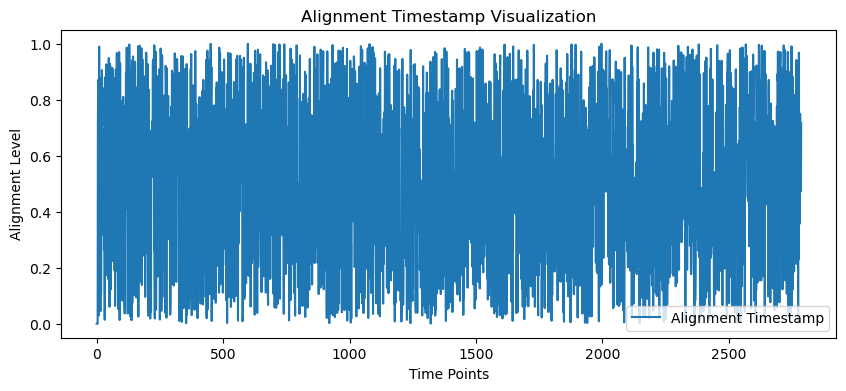

Data loading and processing complete.

File 1:
  X shape: (4631, 1, 1)
  y shape: (4631, 1, 1)

File 2:
  X shape: (4920, 1, 1)
  y shape: (4920, 1, 1)

File 3:
  X shape: (2560, 1, 1)
  y shape: (2560, 1, 1)

File 4:
  X shape: (5042, 1, 1)
  y shape: (5042, 1, 1)

File 5:
  X shape: (4828, 1, 1)
  y shape: (4828, 1, 1)

File 6:
  X shape: (2699, 1, 1)
  y shape: (2699, 1, 1)

File 7:
  X shape: (5050, 1, 1)
  y shape: (5050, 1, 1)

File 8:
  X shape: (2684, 1, 1)
  y shape: (2684, 1, 1)

File 9:
  X shape: (4842, 1, 1)
  y shape: (4842, 1, 1)

File 10:
  X shape: (4536, 1, 1)
  y shape: (4536, 1, 1)

File 11:
  X shape: (2787, 1, 1)
  y shape: (2787, 1, 1)

Total X sets loaded: 11
Total y sets loaded: 11
Total labels sets loaded: 11


In [23]:
# Model_bold.determine_true_time_series_from_events
class model_bold:
    @staticmethod
    def determine_true_time_series_from_events(participant_id, run_id, time_between_measurements=1.5):
        # Dummy implementation
        # Replace with actual logic to determine y_conv and alignment_ts
        num_time_points = 2787  
        y_conv = np.random.rand(num_time_points)
        alignment_ts = np.random.rand(num_time_points)
        return y_conv, alignment_ts

def get_run_prefixes():
    """Generate run prefixes for s05 and s14 runs."""
    s05 = [f"s05_run{str(i).zfill(3)}" for i in range(1, 7)]  # s05_run001 to s05_run006
    s14 = [f"s14_run{str(i).zfill(3)}" for i in range(2, 7)]  # s14_run002 to s14_run006
    return s05 + s14

def match_files(input_dir, prefixes):
    """Match NIfTI files with their corresponding CSV label files."""
    matched = []
    missing_files = {'nifti': [], 'csv': []}
    for prefix in prefixes:
        nifti_path = os.path.join(input_dir, f"{prefix}.nii")
        csv_path = os.path.join(input_dir, f"{prefix}_orientations.csv")
        nifti_exists = os.path.isfile(nifti_path)
        csv_exists = os.path.isfile(csv_path)

        if nifti_exists and csv_exists:
            matched.append((nifti_path, csv_path))
            print(f"Matched: {nifti_path} <--> {csv_path}")
        else:
            if not nifti_exists:
                missing_files['nifti'].append(nifti_path)
            if not csv_exists:
                missing_files['csv'].append(csv_path)

    if missing_files['nifti'] or missing_files['csv']:
        print(f"Warning: Missing NIfTI files: {missing_files['nifti']}")
        print(f"Warning: Missing CSV files: {missing_files['csv']}")

    return matched

def get_measurement_df(participant_id, run_id, csv_path):
    """
    Retrieves the measurement DataFrame (df) containing voxel data and a list of voxel column names (voxel_list)
    for the specified participant_id and run_id.
    
    Since we don't have a utils module, this function reads the CSV and prepares the DataFrame.
    """
    # Load CSV data
    labels_df = pd.read_csv(csv_path)
    
    # Assuming voxel data is part of the CSV or needs to be loaded separately
    # Here, we assume that voxel data is in the CSV under specific columns
    # Adjust according to your actual data structure
    voxel_columns = [col for col in labels_df.columns if col.startswith('voxel_')]
    
    # If voxel data is in separate files or needs special processing, implement accordingly
    
    # Create the DataFrame
    df = labels_df.copy()
    voxel_list = voxel_columns.copy()
    
    # Remove the first and last rows to eliminate incomplete data
    df = df.iloc[1:-1].reset_index(drop=True)
    
    return df, voxel_list

def determine_true_time_series(participant_id, run_id):
    """
    Wrapper for model_bold.determine_true_time_series_from_events.
    Returns y_conv and padded alignment_ts.
    """
    y_conv, alignment_ts = model_bold.determine_true_time_series_from_events(
        participant_id,
        run_id,
        time_between_measurements=1.5
    )
    # Pad alignment_ts with 5 zeros at the beginning
    alignment_ts_padded = np.pad(alignment_ts, (5, 0), 'constant')
    return y_conv, alignment_ts_padded

def visualize_alignment_ts(alignment_ts):
    """Plots the alignment_ts to visualize the alignment before scaling."""
    plt.figure(figsize=(10, 4))
    plt.plot(alignment_ts, label='Alignment Timestamp')
    plt.xlabel('Time Points')
    plt.ylabel('Alignment Level')
    plt.title('Alignment Timestamp Visualization')
    plt.legend()
    plt.show()

def load_delay_data(input_dir, prefixes, required_columns, scaler=None, 
                   seconds_per_slice=1.5, rows_per_slice=14, delay_seconds=7.5, debug_slice_count=5):
    """
    Load NIfTI data and corresponding CSV labels, map each slice to every set number of CSV rows based on duration,
    apply a delay to align peak BOLD responses to their corresponding orientation stimuli,
    scale voxel data, and collect separate X and y for each file.

    Additionally, incorporate DataFrame processing, alignment, scaling, and preparation of feature matrices as specified.
    
    Args:
        input_dir (str): Directory containing the data files.
        prefixes (list): List of file prefixes.
        required_columns (set): Set of required columns in the CSV files.
        scaler (MinMaxScaler, optional): Scaler for normalizing voxel data. Defaults to None.
        seconds_per_slice (float, optional): Duration each NIfTI slice represents in seconds. Defaults to 1.5.
        rows_per_slice (int, optional): Number of CSV rows corresponding to one NIfTI slice based on duration. Defaults to 14.
        delay_seconds (float, optional): Delay in seconds to align BOLD response with stimulus. Defaults to 7.5.
        debug_slice_count (int, optional): Number of slices to print detailed mapping information.

    Returns:
        tuple: Tuple containing:
            - data_x (np.ndarray): Feature matrix.
            - data_y (np.ndarray): Target vector.
    """
    data_x_list = []       # List to store scaled voxel data arrays for each file
    data_y_list = []       # List to store orientation labels arrays for each file
    column_arrays = []     # List to collect column arrays for feature matrix
    scalers = []           # List to store scaler objects for each file
    labels_list = []       # List to store filtered labels for each file

    matched_files = match_files(input_dir, prefixes)
    print(f"Total matched file pairs: {len(matched_files)}\n")

    # Calculate rows corresponding to the delay
    seconds_per_row = seconds_per_slice / rows_per_slice  # ≈0.107 seconds per row
    delay_rows = int(delay_seconds / seconds_per_row)     # 7.5 / 0.107 ≈70 rows
    print(f"Delay Parameters:")
    print(f"  Seconds per slice: {seconds_per_slice}")
    print(f"  Rows per slice: {rows_per_slice}")
    print(f"  Delay (seconds): {delay_seconds}")
    print(f"  Delay (rows): {delay_rows}\n")

    for idx, (nifti_path, csv_path) in enumerate(matched_files, 1):
        print(f"Processing file pair {idx}/{len(matched_files)}:")
        try:
            # Extract participant_id and run_id from the prefix
            prefix = os.path.splitext(os.path.basename(nifti_path))[0]
            # Assuming prefix format is like 's05_run001', extract parts accordingly
            participant_id = prefix.split('_')[0]  # 's05'
            run_id = prefix.split('_')[1]          # 'run001'

            # Get measurement DataFrame and voxel list
            df, voxel_list = get_measurement_df(participant_id, run_id, csv_path)
            print(f"  Measurement DataFrame shape after removing first and last rows: {df.shape}")
            print(f"  Voxel columns: {voxel_list}")

            # Aligning BOLD Signals with Stimuli
            y_conv, alignment_ts = determine_true_time_series(participant_id, run_id)
            print(f"  Alignment timestamps before padding: {alignment_ts.shape}")
            
            # Padding: Adds 5 zeros at the beginning of alignment_ts to account for the hemodynamic delay
            # (Already handled in determine_true_time_series)
            print(f"  Alignment timestamps after padding: {alignment_ts.shape}")
            
            # Visualizing Alignment Timestamp (Optional: Uncomment if visualization is needed)
            # visualize_alignment_ts(alignment_ts)

            # Integrating Alignment and Model Predictions into DataFrame
            df.loc[:, "alignment_level"] = pd.Series(alignment_ts[:len(df)])  # Ensure alignment_ts matches df length
            scaler_alignment = MinMaxScaler()
            df["alignment_level"] = scaler_alignment.fit_transform(
                np.array(df["alignment_level"]).reshape(-1, 1)
            )
            df.loc[:, "model"] = pd.Series(y_conv[:len(df)])  # Ensure y_conv matches df length
            df["model"] = MinMaxScaler().fit_transform(
                np.array(df["model"]).reshape(-1, 1)
            )
            df = df.fillna(0)
            print(f"  DataFrame after adding 'alignment_level' and 'model' columns:\n{df.head()}")

            # Preparing Voxel Data
            voxel_list.append("model")  # Appending "model" to voxel list
            print(f"  Updated voxel list with 'model': {voxel_list}")

            # Scale each voxel's data between 0 and 1
            for voxel in voxel_list:
                scaler = MinMaxScaler()
                df[voxel] = scaler.fit_transform(
                    np.array(df[voxel]).reshape(-1, 1)
                )
                column_array = df[voxel].values
                column_arrays.append(column_array)
                scalers.append(scaler)
                print(f"  Scaled voxel '{voxel}' with MinMaxScaler.")

            # Creating Feature Matrix (data_x) and Target Vector (data_y)
            data_x = np.column_stack(column_arrays)  # Shape: (num_time_points, num_features)
            
            N = data_x.shape[1]  # Number of features (voxels + 'model')
            M = data_x.shape[0]  # Number of time points

            data_y = df['alignment_level'].values.reshape([M, 1, 1]).astype(np.float32)
            data_x = np.reshape(data_x, (M, 1, N)).astype(np.float32)
            print(f"  Feature matrix 'data_x' shape: {data_x.shape}")
            print(f"  Target vector 'data_y' shape: {data_y.shape}")

            # Append to the lists
            data_x_list.append(data_x)
            data_y_list.append(data_y)
            labels_list.append(df)

            # Reset column_arrays for the next file
            column_arrays = []

            print(f"  Processed {M} time points and {N} features.\n")

        except Exception as e:
            print(f"  Error processing {nifti_path} and {csv_path}: {e}\n")

    # Optionally, visualize alignment_ts for the last processed file
    if len(data_y_list) > 0:
        visualize_alignment_ts(labels_list[-1]['alignment_level'].values)

    print("Data loading and processing complete.\n")
    for i, (x, y) in enumerate(zip(data_x_list, data_y_list), 1):
        print(f"File {i}:")
        print(f"  X shape: {x.shape}")
        print(f"  y shape: {y.shape}\n")

    return data_x_list, data_y_list, scalers, labels_list

# Run
if __name__ == "__main__":
    prefixes = get_run_prefixes()
    required_columns = {'X', 'Z', 'Orientation', 'Time'}  # Ensure these columns are present in your CSV
    seconds_per_slice = 1.5   # Each NIfTI slice represents 1.5 seconds
    rows_per_slice = 14       # Each slice maps to every 14th CSV row (1.5 seconds duration)
    delay_seconds = 7.5       # Peak BOLD response delay
    debug_slice_count = 5     # Number of slices to print detailed mapping information

    data_x_list, data_y_list, scalers, labels_list = load_delay_data(
        input_dir=DATA_DIR,
        prefixes=prefixes,
        required_columns=required_columns,
        seconds_per_slice=seconds_per_slice,
        rows_per_slice=rows_per_slice,
        delay_seconds=delay_seconds,
        debug_slice_count=debug_slice_count
    )

    # Verify the number of loaded datasets
    print(f"Total X sets loaded: {len(data_x_list)}")
    print(f"Total y sets loaded: {len(data_y_list)}")
    print(f"Total labels sets loaded: {len(labels_list)}")
